In [2]:
# Importing packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter

In [3]:
# Loading dataset and viewing data
df = pd.read_csv(r'C:\Users\Lenovo\Desktop\my_random_projects\Decision_Tree\winequality-red.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [4]:
df.info(), df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


(None, (1599, 12))

###### No categorical column!

# Cleaning and Preprocessing

#### Handling null values

In [5]:
df.isnull().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

#### Handling Duplicates

In [6]:
# Checking duplicates
df.duplicated().sum()

240

In [7]:
# Dropping duplicates
df.drop_duplicates(inplace=True)
df.shape

(1359, 12)

#### Feature Selection

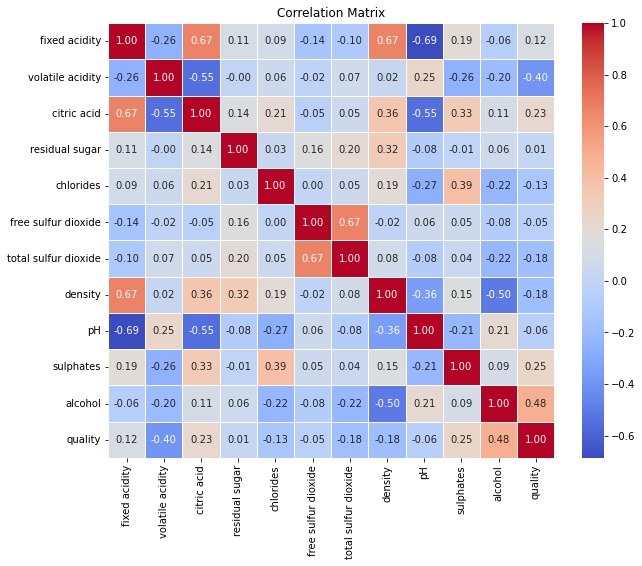

In [8]:
# Checking correlation between features and target
corr_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()

###### Can remove some features because of having a high correlation with eachother but since this is a non linear model, it is not sensetive to multicollinearity.

#### Outlier Detection

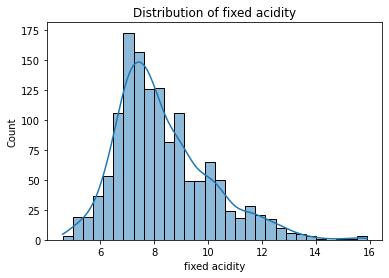

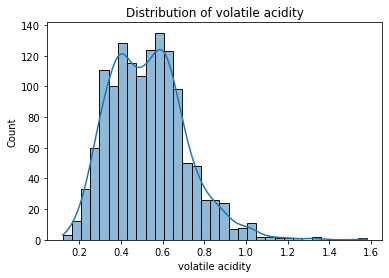

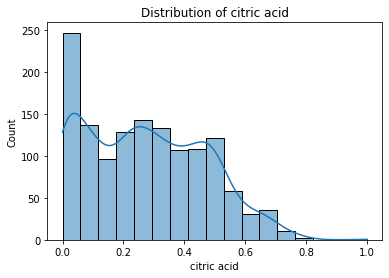

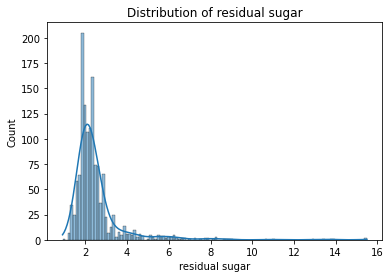

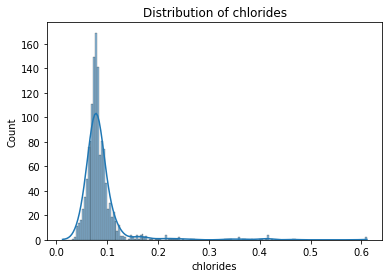

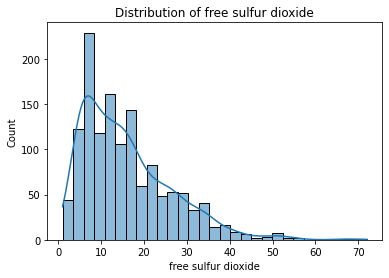

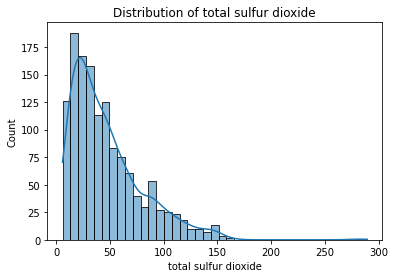

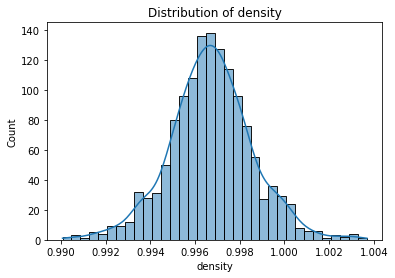

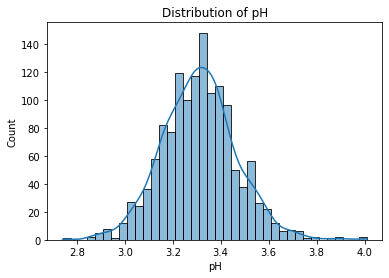

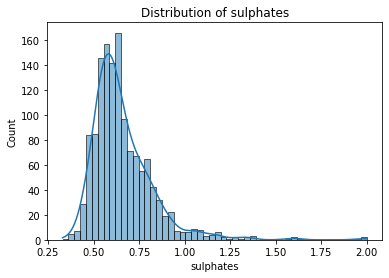

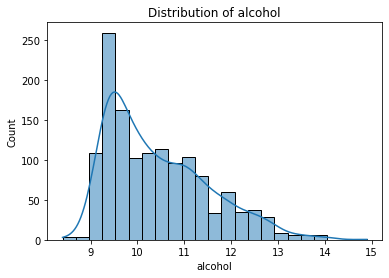

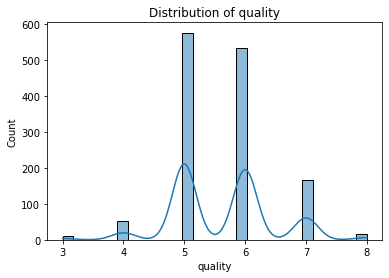

In [9]:
# checking skewness for each feature
for col in df.columns:
    if df[col].dtype != 'object':
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.show()

###### Choosing the outlier detection method based on the feature distribution.
###### Z-score for Normal and Guassian distribution and IQR for  Non-Normal features.

In [10]:
normal_dist = df[['density', 'pH']]
non_normal_dist = df[[col for col in df.columns if col not in list(normal_dist) + ['quality']]]
label = df[['quality']]

In [11]:
# calculating z-score for normal distributed features
def z_score_calc(df):  
    z_scores = (df - df.mean()) / df.std()
    return z_scores
    
def z_filter(df):
    df['outlier1'] = False
    # return (df[(df< 3).all(axis=1) & (df > -3).all(axis=1)]) #.all(axis=1) checks all rows
    for col in df.columns:
        df.loc[((df[col] > 3) | (df[col] < -3)), 'outlier1'] = True
    return df
    
# calculating IQR for non normal distributed features
def IQR(df):
    iqr = df.quantile(0.75) - df.quantile(0.25)
    lower_bound = df.quantile(0.25) - (1.5 * iqr)
    upper_bound = df.quantile(0.75) + (1.5* iqr)
    return lower_bound, upper_bound

In [12]:
# Removing outliers

normal_dist = z_score_calc(normal_dist)
normal_dist = z_filter(normal_dist)

lower, upper = IQR(non_normal_dist)
non_normal_dist['outlier2'] = False
for col in non_normal_dist.columns:
    if col != 'outlier2': #Avoid modifying the new column(or you will get an error)
        non_normal_dist.loc[((non_normal_dist[col] < lower[col]) | (non_normal_dist[col] > upper[col])), 'outlier2'] = True


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_20596\2756921086.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_normal_dist['outlier2'] = False
c:\users\lenovo\anaconda3\lib\site-packages\pandas\core\indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [13]:
print((normal_dist.loc[normal_dist['outlier1'] == True]).shape, (non_normal_dist.loc[non_normal_dist['outlier2'] == True]).shape)

(21, 3) (321, 10)


##### the IQR function is labeling over 25% of the data as outliers! removing them is not a good decision.

In [14]:
# Capping and Flooring extreme values instead of removing
for col in non_normal_dist.columns:
    if col != 'outlier2':
        df[col] = np.where(df[col] > upper[col], upper[col], np.where(df[col] < lower[col], lower[col], df[col]))

In [15]:
# Creating the final dataframe without outliers
new_df = pd.merge(normal_dist, non_normal_dist,  left_index=True, right_index=True)
new_df = pd.merge(new_df, label, left_index=True, right_index=True)
new_df = new_df.loc[new_df['outlier1'] == False]
new_df.drop(['outlier1','outlier2'], axis=1, inplace=True)

# Train and Test Split

# Decision Tree from scratch

### Thereshold splitting 

In [78]:
# Calculating middle point for each split
def middle_point(feature: pd.Series) -> list:
    unique_values = feature.sort_values().unique()
    mid_points = []
    for i in range(len(unique_values) - 1):
        mid_point = (unique_values[i] + unique_values[i+1]) / 2
        mid_points.append(mid_point)
    return mid_points

# Splitting data based on different thresholds
def find_threshold1(mid_points_list: list, feature: pd.Series, df_label: pd.Series) -> pd.DataFrame:   
    for m in mid_points_list:
        labels = []
        point = [m] * len(feature)
        for val in feature:
            if val <= m:
                labels.append('Left')
            else:
                labels.append('Right')
        df_threshold = pd.DataFrame({'middle_points': point, 
                                     'split_label': labels, 
                                     'label': df_label.values})
    return df_threshold  

# Calculating Gini
def calc_gini(df: pd.DataFrame):
    item_counts = Counter(label_col)
    gini = 1
    for i in item_counts:
        p = (item_counts[i] / len(label_col)) **2
        gini = gini - p 
    return gini

    

In [70]:
find_threshold1(middle_point(new_df['alcohol']), new_df['alcohol'], new_df['quality'])

,middle_points,split_label,label
0,14.45,Left,5
1,14.45,Left,5
2,14.45,Left,5
3,14.45,Left,6
4,14.45,Left,5
...,...,...,...
1333,14.45,Left,6
1334,14.45,Left,5
1335,14.45,Left,6
1336,14.45,Left,5
